<a href="https://colab.research.google.com/github/feapri/tensorflow_practice/blob/master/U3_Classifying_Images_of_Clothing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##### Copyright 2018 The TensorFlow Authors.

In [0]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [0]:
#@title MIT License
#
# Copyright (c) 2017 François Chollet
#
# Permission is hereby granted, free of charge, to any person obtaining a
# copy of this software and associated documentation files (the "Software"),
# to deal in the Software without restriction, including without limitation
# the rights to use, copy, modify, merge, publish, distribute, sublicense,
# and/or sell copies of the Software, and to permit persons to whom the
# Software is furnished to do so, subject to the following conditions:
#
# The above copyright notice and this permission notice shall be included in
# all copies or substantial portions of the Software.
#
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL
# THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING
# FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER
# DEALINGS IN THE SOFTWARE.

# Classifying Images of Clothing

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/examples/blob/master/courses/udacity_intro_to_tensorflow_for_deep_learning/l03c01_classifying_images_of_clothing.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/examples/blob/master/courses/udacity_intro_to_tensorflow_for_deep_learning/l03c01_classifying_images_of_clothing.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

In this tutorial, we'll build and train a neural network to classify images of clothing, like sneakers and shirts.

It's okay if you don't understand everything. This is a fast-paced overview of a complete TensorFlow program, with explanations along the way. The goal is to get the general sense of a TensorFlow project, not to catch every detail.

This guide uses [tf.keras](https://www.tensorflow.org/guide/keras), a high-level API to build and train models in TensorFlow.

## Install and import dependencies

We'll need [TensorFlow Datasets](https://www.tensorflow.org/datasets/), an API that simplifies downloading and accessing datasets, and provides several sample datasets to work with. We're also using a few helper libraries.

In [0]:
!pip install -U tensorflow_datasets

In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals

In [0]:
try:
  # Use the %tensorflow_version magic if in colab.
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf

In [0]:
# Import TensorFlow Datasets
import tensorflow_datasets as tfds
tfds.disable_progress_bar()

# Helper libraries
import math
import numpy as np
import matplotlib.pyplot as plt

In [0]:
import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

In [31]:
# Check versions
str1 = !python -V
print('python.version: {}'.format(str(str1)[2:-2]))
print('tf.__version__: {}'.format(tf.__version__))
print('tfds.__version__: {}'.format(tfds.__version__))
str1 = tfds.list_builders()
print('\n{:<30}{:<32}\n'.format('', 'Available datasets'))
it = iter(str1)
for i in it:
  print('{:<35}{:<32}{:<30}{}'.format(i, next(it, ""), next(it, ""), next(it, "")))

python.version: Python 3.6.8
tf.__version__: 2.0.0-rc2
tfds.__version__: 1.2.0

                              Available datasets              

abstract_reasoning                 aflw2k3d                        amazon_us_reviews             bair_robot_pushing_small
bigearthnet                        binarized_mnist                 binary_alpha_digits           caltech101
caltech_birds2010                  caltech_birds2011               cats_vs_dogs                  celeb_a
celeb_a_hq                         chexpert                        cifar10                       cifar100
cifar10_corrupted                  clevr                           cnn_dailymail                 coco
coco2014                           coil100                         colorectal_histology          colorectal_histology_large
curated_breast_imaging_ddsm        cycle_gan                       deep_weeds                    definite_pronoun_resolution
diabetic_retinopathy_detection     downsampled_imagenet         

## Import the Fashion MNIST dataset

This guide uses the [Fashion MNIST](https://github.com/zalandoresearch/fashion-mnist) dataset, which contains 70,000 grayscale images in 10 categories. The images show individual articles of clothing at low resolution (28 $\times$ 28 pixels), as seen here:

<table>
  <tr><td>
    <img src="https://tensorflow.org/images/fashion-mnist-sprite.png"
         alt="Fashion MNIST sprite" width="600">
  </td></tr>
  <tr><td align="center">
    <b>Figure 1.</b> <a href="https://github.com/zalandoresearch/fashion-mnist">Fashion-MNIST samples</a> (by Zalando, MIT License).<br/>&nbsp;
  </td></tr>
</table>

Fashion MNIST is intended as a drop-in replacement for the classic [MNIST](http://yann.lecun.com/exdb/mnist/) dataset—often used as the "Hello, World" of machine learning programs for computer vision. The MNIST dataset contains images of handwritten digits (0, 1, 2, etc) in an identical format to the articles of clothing we'll use here.

This guide uses Fashion MNIST for variety, and because it's a slightly more challenging problem than regular MNIST. Both datasets are relatively small and are used to verify that an algorithm works as expected. They're good starting points to test and debug code.

We will use 60,000 images to train the network and 10,000 images to evaluate how accurately the network learned to classify images. You can access the Fashion MNIST directly from TensorFlow, using the [Datasets](https://www.tensorflow.org/datasets) API:

In [32]:
# Records 0 (included) to 99 (excluded).
tfds.load("fashion_mnist:3.*.*", split="test[:99%]")

<_OptionsDataset shapes: {image: (28, 28, 1), label: ()}, types: {image: tf.uint8, label: tf.int64}>

In [33]:
dataset, metadata = tfds.load('fashion_mnist:3.*.*', as_supervised=True, with_info=True, shuffle_files=True)#, split="test[:99%]")
metadata

tfds.core.DatasetInfo(
    name='fashion_mnist',
    version=3.0.0,
    description='Fashion-MNIST is a dataset of Zalando's article images consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image, associated with a label from 10 classes.',
    urls=['https://github.com/zalandoresearch/fashion-mnist'],
    features=FeaturesDict({
        'image': Image(shape=(28, 28, 1), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
    }),
    total_num_examples=70000,
    splits={
        'test': 10000,
        'train': 60000,
    },
    supervised_keys=('image', 'label'),
    citation="""@article{DBLP:journals/corr/abs-1708-07747,
      author    = {Han Xiao and
                   Kashif Rasul and
                   Roland Vollgraf},
      title     = {Fashion-MNIST: a Novel Image Dataset for Benchmarking Machine Learning
                   Algorithms},
      journal   = {CoRR},
      volume  

In [0]:
dataset, metadata = tfds.load('fashion_mnist:3.*.*', as_supervised=True, with_info=True, shuffle_files=True)
train_dataset, test_dataset = dataset['train'], dataset['test']


In [35]:
dataset

{'test': <_OptionsDataset shapes: ((28, 28, 1), ()), types: (tf.uint8, tf.int64)>,
 'train': <_OptionsDataset shapes: ((28, 28, 1), ()), types: (tf.uint8, tf.int64)>}

Loading the dataset returns metadata as well as a *training dataset* and *test dataset*.

* The model is trained using `train_dataset`.
* The model is tested against `test_dataset`.

The images are 28 $\times$ 28 arrays, with pixel values in the range `[0, 255]`. The *labels* are an array of integers, in the range `[0, 9]`. These correspond to the *class* of clothing the image represents:

<table>
  <tr>
    <th>Label</th>
    <th>Class</th>
  </tr>
  <tr>
    <td>0</td>
    <td>T-shirt/top</td>
  </tr>
  <tr>
    <td>1</td>
    <td>Trouser</td>
  </tr>
    <tr>
    <td>2</td>
    <td>Pullover</td>
  </tr>
    <tr>
    <td>3</td>
    <td>Dress</td>
  </tr>
    <tr>
    <td>4</td>
    <td>Coat</td>
  </tr>
    <tr>
    <td>5</td>
    <td>Sandal</td>
  </tr>
    <tr>
    <td>6</td>
    <td>Shirt</td>
  </tr>
    <tr>
    <td>7</td>
    <td>Sneaker</td>
  </tr>
    <tr>
    <td>8</td>
    <td>Bag</td>
  </tr>
    <tr>
    <td>9</td>
    <td>Ankle boot</td>
  </tr>
</table>

Each image is mapped to a single label. Since the *class names* are not included with the dataset, store them here to use later when plotting the images:

In [0]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal',      'Shirt',   'Sneaker',  'Bag',   'Ankle boot']

### Explore the data

Let's explore the format of the dataset before training the model. The following shows there are 60,000 images in the training set, and 10000 images in the test set:

In [37]:
metadata.splits

{'test': <tfds.core.SplitInfo num_examples=10000>,
 'train': <tfds.core.SplitInfo num_examples=60000>}

In [0]:
num_train_examples = metadata.splits['train'].num_examples
num_test_examples = metadata.splits['test'].num_examples
print("Number of training examples: {}".format(num_train_examples))
print("Number of test examples:     {}".format(num_test_examples))

## Preprocess the data

The value of each pixel in the image data is an integer in the range `[0,255]`. For the model to work properly, these values need to be normalized to the range `[0,1]`. So here we create a normalization function, and then apply it to each image in the test and train datasets.

In [0]:
def normalize(images, labels):
  images = tf.cast(images, tf.float32)
  images /= 255
  return images, labels

# The map function applies the normalize function to each element in the train
# and test datasets
train_dataset =  train_dataset.map(normalize)
test_dataset  =  test_dataset.map(normalize)

### Explore the processed data

Let's plot an image to see what it looks like.

In [0]:
# Take a single image, and remove the color dimension by reshaping
for image, label in test_dataset.take(1):
  break
image = image.numpy().reshape((28,28))

# Plot the image - voila a piece of fashion clothing
plt.figure()
plt.imshow(image, cmap=plt.cm.binary)
plt.colorbar()
plt.grid(False)
plt.show()

Display the first 25 images from the *training set* and display the class name below each image. Verify that the data is in the correct format and we're ready to build and train the network.

In [0]:
plt.figure(figsize=(6, 6))
i = 0
for (image, label) in test_dataset.take(25):
    image = image.numpy().reshape((28,28))
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(image, cmap=plt.cm.binary)
    plt.xlabel(class_names[label])
    i += 1
plt.show()

## Build the model

Building the neural network requires configuring the layers of the model, then compiling the model.

### Setup the layers

The basic building block of a neural network is the *layer*. A layer extracts a representation from the data fed into it. Hopefully, a series of connected layers results in a representation that is meaningful for the problem at hand.

Much of deep learning consists of chaining together simple layers. Most layers, like `tf.keras.layers.Dense`, have internal parameters which are adjusted ("learned") during training.

In [0]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28, 1)),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(10,  activation=tf.nn.softmax)
])

This network has three layers:

* **input** `tf.keras.layers.Flatten` — This layer transforms the images from a 2d-array of 28 $\times$ 28 pixels, to a 1d-array of 784 pixels (28\*28). Think of this layer as unstacking rows of pixels in the image and lining them up. This layer has no parameters to learn, as it only reformats the data.

* **"hidden"** `tf.keras.layers.Dense`— A densely connected layer of 128 neurons. Each neuron (or node) takes input from all 784 nodes in the previous layer, weighting that input according to hidden parameters which will be learned during training, and outputs a single value to the next layer.

* **output** `tf.keras.layers.Dense` — A 10-node *softmax* layer, with each node representing a class of clothing. As in the previous layer, each node takes input from the 128 nodes in the layer before it. Each node weights the input according to learned parameters, and then outputs a value in the range `[0, 1]`, representing the probability that the image belongs to that class. The sum of all 10 node values is 1.


### Compile the model

Before the model is ready for training, it needs a few more settings. These are added during the model's *compile* step:


* *Loss function* — An algorithm for measuring how far the model's outputs are from the desired output. The goal of training is this measures loss.
* *Optimizer* —An algorithm for adjusting the inner parameters of the model in order to minimize loss.
* *Metrics* —Used to monitor the training and testing steps. The following example uses *accuracy*, the fraction of the images that are correctly classified.

In [0]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

## Train the model

First, we define the iteration behavior for the train dataset:
1. Repeat forever by specifying `dataset.repeat()` (the `epochs` parameter described below limits how long we perform training).
2. The `dataset.shuffle(60000)` randomizes the order so our model cannot learn anything from the order of the examples.
3. And `dataset.batch(32)` tells `model.fit` to use batches of 32 images and labels when updating the model variables.

Training is performed by calling the `model.fit` method:
1. Feed the training data to the model using `train_dataset`.
2. The model learns to associate images and labels.
3. The `epochs=5` parameter limits training to 5 full iterations of the training dataset, so a total of 5 * 60000 = 300000 examples.

(Don't worry about `steps_per_epoch`, the requirement to have this flag will soon be removed.)

In [0]:
BATCH_SIZE = 32
train_dataset = train_dataset.repeat().shuffle(num_train_examples).batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)

In [0]:
model.fit(train_dataset, epochs=5, steps_per_epoch=math.ceil(num_train_examples/BATCH_SIZE))

As the model trains, the loss and accuracy metrics are displayed. This model reaches an accuracy of about 0.88 (or 88%) on the training data.

## Evaluate accuracy

Next, compare how the model performs on the test dataset. Use all examples we have in the test dataset to assess accuracy.

In [0]:
test_loss, test_accuracy = model.evaluate(test_dataset, steps=math.ceil(num_test_examples/32))
print('Accuracy on test dataset:', test_accuracy)

As it turns out, the accuracy on the test dataset is smaller than the accuracy on the training dataset. This is completely normal, since the model was trained on the `train_dataset`. When the model sees images it has never seen during training, (that is, from the `test_dataset`), we can expect performance to go down. 

## Make predictions and explore

With the model trained, we can use it to make predictions about some images.

In [0]:
for test_images, test_labels in test_dataset.take(1):
  test_images = test_images.numpy()
  test_labels = test_labels.numpy()
  predictions = model.predict(test_images)

In [0]:
predictions.shape


Here, the model has predicted the label for each image in the testing set. Let's take a look at the first prediction:

In [0]:
predictions[0]

A prediction is an array of 10 numbers. These describe the "confidence" of the model that the image corresponds to each of the 10 different articles of clothing. We can see which label has the highest confidence value:

In [0]:
np.argmax(predictions[0])

So the model is most confident that this image is a shirt, or `class_names[6]`. And we can check the test label to see this is correct:

In [0]:
test_labels[0]

We can graph this to look at the full set of 10 class predictions

In [0]:
def plot_image(i, predictions_array, true_labels, images):
  predictions_array, true_label, img = predictions_array[i], true_labels[i], images[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  
  plt.imshow(img[...,0], cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'
  
  plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  predictions_array, true_label = predictions_array[i], true_label[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  thisplot = plt.bar(range(10), predictions_array, color="#777777")
  plt.ylim([0, 1]) 
  predicted_label = np.argmax(predictions_array)
  
  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

Let's look at the 0th image, predictions, and prediction array. 

In [0]:
i = 0
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions, test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions, test_labels)

In [0]:
i = 12
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions, test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions, test_labels)

Let's plot several images with their predictions. Correct prediction labels are blue and incorrect prediction labels are red. The number gives the percent (out of 100) for the predicted label. Note that it can be wrong even when very confident. 

In [0]:
# Plot the first X test images, their predicted label, and the true label
# Color correct predictions in blue, incorrect predictions in red
num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i, predictions, test_labels, test_images)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(i, predictions, test_labels)


Finally, use the trained model to make a prediction about a single image. 

In [0]:
# Grab an image from the test dataset
img = test_images[0]

print(img.shape)

`tf.keras` models are optimized to make predictions on a *batch*, or collection, of examples at once. So even though we're using a single image, we need to add it to a list:

In [0]:
# Add the image to a batch where it's the only member.
img = np.array([img])

print(img.shape)

Now predict the image:

In [0]:
predictions_single = model.predict(img)

print(predictions_single)

In [0]:
plot_value_array(0, predictions_single, test_labels)
_ = plt.xticks(range(10), class_names, rotation=45)

`model.predict` returns a list of lists, one for each image in the batch of data. Grab the predictions for our (only) image in the batch:

In [0]:
np.argmax(predictions_single[0])

And, as before, the model predicts a label of 6 (shirt).

# Exercises

Experiment with different models and see how the accuracy results differ. In particular change the following parameters:
*   Set training epochs set to 1
*   Number of neurons in the Dense layer following the Flatten one. For example, go really low (e.g. 10) in ranges up to 512 and see how accuracy changes
*   Add additional Dense layers between the Flatten and the final Dense(10, activation=tf.nn.softmax), experiment with different units in these layers
*   Don't normalize the pixel values, and see the effect that has


Remember to enable GPU to make everything run faster (Runtime -> Change runtime type -> Hardware accelerator -> GPU).
Also, if you run into trouble, simply reset the entire environment and start from the beginning:
*   Edit -> Clear all outputs
*   Runtime -> Reset all runtimes

**************************************
**************************************
# KERAS
 - **Restart the kernel and run fron here and below**
**************************************
**************************************

References: 
- https://pravarmahajan.github.io/fashion/
- https://www.tensorflow.org/tutorials/keras/classification



In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals

try:
  # Use the %tensorflow_version magic if in colab.
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import fashion_mnist

#from keras.layers import Conv2D, MaxPool2D, Flatten
#from keras.layers import Dense, Dropout

In [22]:
# Check versions
str1 = !python -V
print('python.version: {}'.format(str(str1)[2:-2]))
print('tf.__version__: {}'.format(tf.__version__))
print('keras.__version__: {}'.format(keras.__version__))


python.version: Python 3.6.8
tf.__version__: 2.0.0-rc2
keras.__version__: 2.2.4-tf


In [0]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

In [0]:
#(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()


In [37]:
x_train.shape

(60000, 28, 28)

In [38]:
x_train[0]

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   1,
          0,   0,  13,  73,   0,   0,   1,   4,   0,   0,   0,   0,   1,
          1,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   3,
          0,  36, 136, 127,  62,  54,   0,   0,   0,   1,   3,   4,   0,
          0,   3],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   6,
          0, 102, 204, 176, 134, 144, 123,  23,   0,   0,   0,   0,  12,
         10,   0],
       [  

In [39]:
y_train[0:10]

array([9, 0, 0, 3, 0, 2, 7, 2, 5, 5], dtype=uint8)

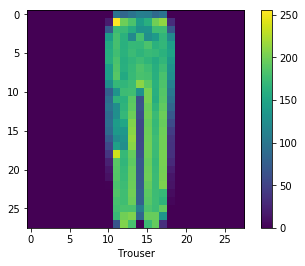

In [40]:
i=1000
plt.figure()
plt.imshow(x_train[i])
plt.colorbar()
plt.grid(False)
plt.xlabel(class_names[y_train[i]])

plt.show()

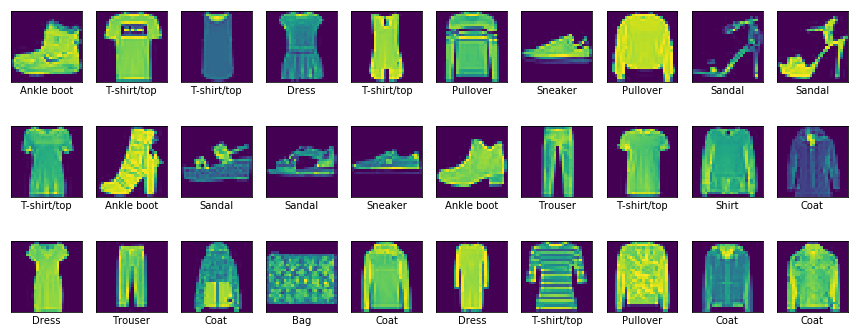

In [41]:
plt.figure(figsize=(15, 6))
rows, cols = 3, 10
for i in range(30):
    plt.subplot(rows, cols,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[i])
    plt.xlabel(class_names[y_train[i]])
plt.show()

In [0]:
# Normalize the data (values to a range of 0 to 1 before feeding them to the neural network model)
x_train = x_train / 255.0
Y_test = y_test / 255.0

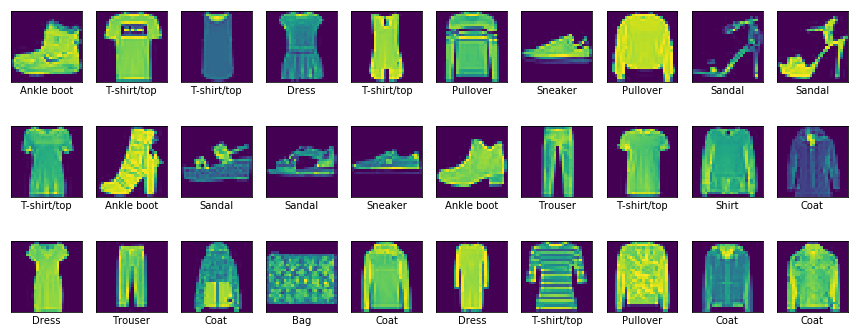

In [43]:
plt.figure(figsize=(15, 6))
rows, cols = 3, 10
for i in range(30):
    plt.subplot(rows, cols,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[i])
    plt.xlabel(class_names[y_train[i]])
plt.show()

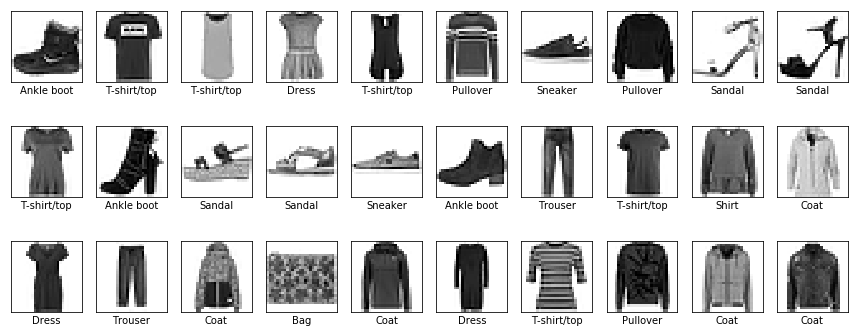

In [44]:
# same as above but adding cmap=plt.cm.binary
plt.figure(figsize=(15, 6))
rows, cols = 3, 10
for i in range(30):
    plt.subplot(rows, cols,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[y_train[i]])
plt.show()

## Build the model
The first layer in this network, tf.keras.layers.Flatten, transforms the format of the images from a two-dimensional array (of 28 by 28 pixels) to a one-dimensional array (of 28 * 28 = 784 pixels). Think of this layer as unstacking rows of pixels in the image and lining them up. This layer has no parameters to learn; it only reformats the data.

After the pixels are flattened, the network consists of a sequence of two tf.keras.layers.Dense layers. These are densely connected, or fully connected, neural layers. The first Dense layer has 128 nodes (or neurons). The second (and last) layer is a 10-node softmax layer that returns an array of 10 probability scores that sum to 1. Each node contains a score that indicates the probability that the current image belongs to one of the 10 classes.

In [50]:
model = keras.Sequential([
    keras.layers.Flatten(input_shape=(28, 28)),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(10, activation='softmax')
])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               100480    
_________________________________________________________________
dense_3 (Dense)              (None, 10)                1290      
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
_________________________________________________________________


In [48]:
100480/128.0

785.0

In [49]:
784*128

100352

In [52]:
x_train.shape  # The flattening is done in the first layer

(60000, 28, 28)

## Compile the model
Before the model is ready for training, it needs a few more settings. These are added during the model's compile step:

Loss function —This measures how accurate the model is during training. You want to minimize this function to "steer" the model in the right direction.
Optimizer —This is how the model is updated based on the data it sees and its loss function.
Metrics —Used to monitor the training and testing steps. The following example uses accuracy, the fraction of the images that are correctly classified.


In [51]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               100480    
_________________________________________________________________
dense_3 (Dense)              (None, 10)                1290      
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
_________________________________________________________________


### Output Shapes
Notice the column “Output Shape”. Each row in that column represents a tuple, with first element set to None. This first dimension of the output shape represents the size of the batch. Since the model is unsure of the batch size at the moment, it does not want to make any assumptions. In fact, having None as the first argument allows us to feed batches of any number of training examples, as long as the rest of the dimensions match.

For exaple, let us imagine that we had 32 examples in our first batch of inputs fed to the model. Now, each input example is a 28x28 image set, each having 1 channel (grayscale, it would have been 3 in the case of color, 1 each for Red, Green and Blue). That’s why the input_shape argument to the first Conv2D layer is (28, 28, 1), corresponding to height, width and number of channels respectively. Why don’t we need to specify input shape to other layers? Since the model is sequential, the output shape of one layer will be the input shape of the next layer.

## Train the model


In [53]:
model.fit(x_train, y_train, epochs=10)

Train on 60000 samples
Epoch 1/10
60000/60000 [==============================] - 6s 101us/sample - loss: 0.5010 - accuracy: 0.8234
Epoch 2/10
60000/60000 [==============================] - 5s 88us/sample - loss: 0.3718 - accuracy: 0.8647
Epoch 3/10
60000/60000 [==============================] - 5s 89us/sample - loss: 0.3352 - accuracy: 0.8784
Epoch 4/10
60000/60000 [==============================] - 5s 89us/sample - loss: 0.3109 - accuracy: 0.8862
Epoch 5/10
60000/60000 [==============================] - 5s 88us/sample - loss: 0.2922 - accuracy: 0.8921
Epoch 6/10
60000/60000 [==============================] - 5s 88us/sample - loss: 0.2799 - accuracy: 0.8954
Epoch 7/10
60000/60000 [==============================] - 5s 89us/sample - loss: 0.2673 - accuracy: 0.9014
Epoch 8/10
60000/60000 [==============================] - 5s 89us/sample - loss: 0.2564 - accuracy: 0.9046
Epoch 9/10
60000/60000 [==============================] - 5s 89us/sample - loss: 0.2456 - accuracy: 0.9080
Epoch 10/10
6

In [54]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               100480    
_________________________________________________________________
dense_3 (Dense)              (None, 10)                1290      
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
_________________________________________________________________


## Evaluate accuracy
Next, compare how the model performs on the test dataset:


In [57]:
test_loss, test_acc = model.evaluate(x_test,  y_test, verbose=2)

print('\nTest accuracy: {:2.2%}'.format(test_acc))

10000/1 - 1s - loss: 30.7241 - accuracy: 0.8568

Test accuracy: 85.68%


## Make predictions


In [59]:
predictions = model.predict(x_test)
predictions.shape

(10000, 10)

In [159]:
# function for prety printing the array as percentages

import io
from contextlib import redirect_stdout
import ast

# function for prety printing the array as percentages
# capturing the stdout buffer to a string.   without this, the return will be of type 'None' and cannot be used with other types
def ndprint(a, format_string ='{0:.2f}'):
  with io.StringIO() as buf, redirect_stdout(buf):
    print([format_string.format(v,i) for i,v in enumerate(a)])
    s1 = buf.getvalue()
    s1 = ast.literal_eval(s1) # to convert str to list
    return s1

print(type(ndprint(predictions[0], '{0:2.1%}')))

ndprint(predictions[0], '{0:2.1%}')

<class 'list'>


['0.0%',
 '0.0%',
 '0.0%',
 '0.0%',
 '0.0%',
 '0.0%',
 '0.0%',
 '0.0%',
 '0.0%',
 '100.0%']

In [0]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal',      'Shirt',   'Sneaker',  'Bag',   'Ankle boot']

In [77]:
class_names[np.argmax(predictions[0])]

'Ankle boot'

['T-shirt/top: 0.0', 'Trouser: 0.0', 'Pullover: 0.0', 'Dress: 0.0', 'Coat: 0.0', 'Sandal: 0.0', 'Shirt: 0.0', 'Sneaker: 0.0', 'Bag: 1.0', 'Ankle boot: 0.0']


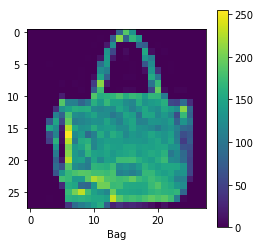

In [168]:
i = 2000
result = map(lambda x, y: x + ': ' + str(y), class_names, predictions[i].tolist())
print(list(result))
plt.figure(figsize = (4, 4))
plt.imshow(x_test[i])
plt.colorbar()
plt.grid(False)
plt.xlabel(class_names[y_test[i]])
plt.show()

[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
['T-shirt/top: 0.0%', 'Trouser: 0.0%', 'Pullover: 0.0%', 'Dress: 0.0%', 'Coat: 0.0%', 'Sandal: 0.0%', 'Shirt: 0.0%', 'Sneaker: 100.0%', 'Bag: 0.0%', 'Ankle boot: 0.0%']


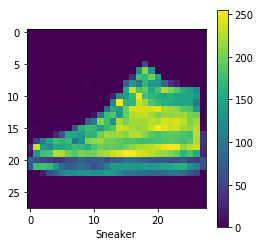

In [169]:
# printing with percentages

i = 1010
result = map(lambda x, y: x + ': ' + y, class_names, (ndprint(predictions[i], '{0:2.1%}')))
print(predictions[i])
print(list(result))
plt.figure(figsize = (4, 4))
plt.imshow(x_test[i])
plt.colorbar()
plt.grid(False)
plt.xlabel(class_names[y_test[i]])
plt.show()

### Plot a few predictions

In [0]:
def plot_image(i, predictions_array, true_label, img):
  predictions_array, true_label, img = predictions_array, true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  predictions_array, true_label = predictions_array, true_label[i]
  plt.grid(False)
  plt.xticks(range(10))
  plt.yticks([])
  thisplot = plt.bar(range(10), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

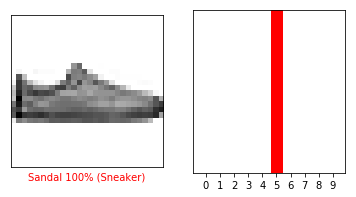

In [184]:
i = 12
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions[i], y_test, x_test)
plt.subplot(1,2,2)
plot_value_array(i, predictions[i],  y_test)
plt.show()

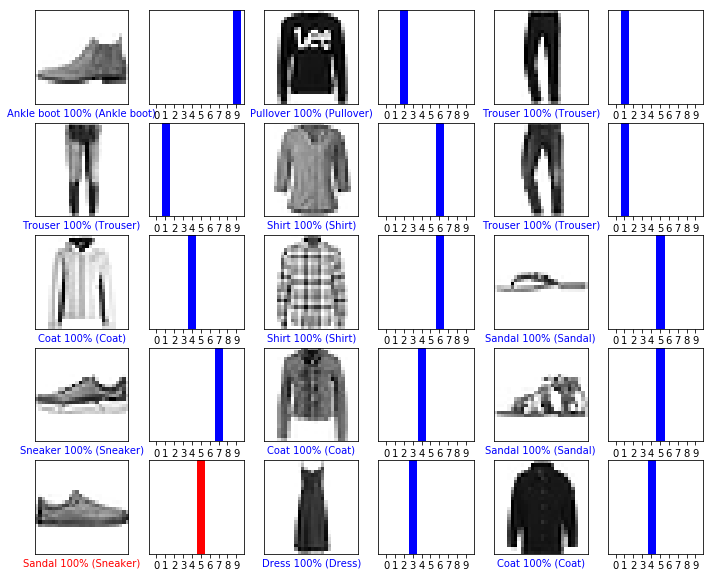

In [183]:
# Plot the first X test images, their predicted label, and the true label
# Color correct predictions in blue, incorrect predictions in red
num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i, predictions[i], y_test, x_test)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(i, predictions[i], y_test)

### use the trained model to make a prediction about a single image.
tf.keras models are optimized to make predictions on a batch, or collection, of examples at once. Accordingly, even though you're using a single image, you need to add it to a list:


In [191]:
# Grab an image from the test dataset.
img = x_test[12]

print(img.shape)

# Add the image to a batch where it's the only member.
img = (np.expand_dims(img,0))

print(img.shape)

(28, 28)
(1, 28, 28)


[[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]]


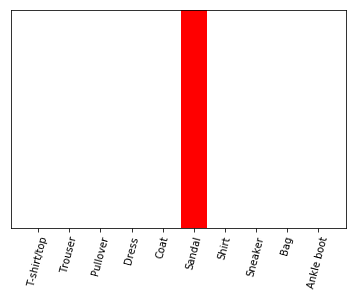

In [192]:
# predict the label for this image:
predictions_single = model.predict(img)
print(predictions_single)

plot_value_array(1, predictions_single[0], y_test)
_ = plt.xticks(range(10), class_names, rotation=75)